# 東京エレクトロン株価（日足）

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-06 00:00:00+09:00,34639.945065,34887.373244,34145.088707,34343.031250,3512000,0.0,0.0
2024-06-07 00:00:00+09:00,34244.059779,34402.413813,33917.454585,34105.500000,1866100,0.0,0.0
2024-06-10 00:00:00+09:00,33996.630579,34432.104158,33877.865057,34422.207031,1740700,0.0,0.0
2024-06-11 00:00:00+09:00,34976.446800,35312.949118,34907.166911,35194.183594,2254100,0.0,0.0
2024-06-12 00:00:00+09:00,34867.578353,35204.080670,34808.195591,35134.800781,1675900,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-02 00:00:00+09:00,23415.000000,23900.000000,23345.000000,23640.000000,4230800,0.0,0.0
2024-12-03 00:00:00+09:00,24280.000000,24790.000000,24220.000000,24650.000000,5934100,0.0,0.0
2024-12-04 00:00:00+09:00,25005.000000,25260.000000,24425.000000,24655.000000,4230700,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

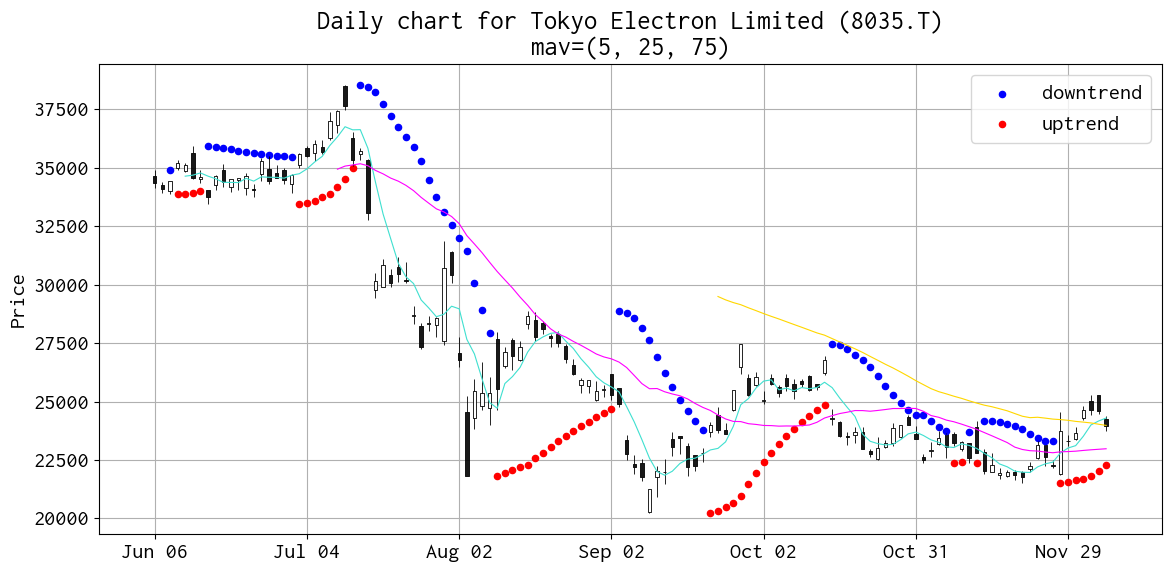

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-12-05 00:00:00+09:00    24585.0
2024-12-06 00:00:00+09:00    23950.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-12-05 00:00:00+09:00      NaN
2024-12-06 00:00:00+09:00   -635.0
Name: Close, dtype: float64

## 東京エレクトロン（後場）

In [6]:
df2 = ticker.history(period='1d', interval='1m')
dt_noon = pd.to_datetime('%s 12:00:00+09:00' % str(df2.index[0].date()))
print(dt_noon)
df2[df2.index > dt_noon]

2024-12-06 12:00:00+09:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-06 12:30:00+09:00,23885.0,23910.0,23875.0,23905.0,2201700,0.0,0.0
2024-12-06 12:31:00+09:00,23905.0,23905.0,23890.0,23895.0,9800,0.0,0.0
2024-12-06 12:32:00+09:00,23895.0,23895.0,23875.0,23880.0,8800,0.0,0.0
2024-12-06 12:33:00+09:00,23885.0,23895.0,23830.0,23840.0,33100,0.0,0.0
2024-12-06 12:34:00+09:00,23840.0,23875.0,23830.0,23860.0,14800,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-06 15:20:00+09:00,23900.0,23910.0,23900.0,23910.0,2300,0.0,0.0
2024-12-06 15:21:00+09:00,23905.0,23915.0,23905.0,23910.0,5300,0.0,0.0
2024-12-06 15:22:00+09:00,23910.0,23910.0,23900.0,23900.0,6100,0.0,0.0


# Tokyo Electron Limited (ADR)

In [7]:
symbol1 = 'TOELY'
ticker1 = yf.Ticker(symbol1)

df1 = ticker1.history(period='6mo')
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-06 00:00:00-04:00,114.000000,114.000000,109.279999,110.669998,487900,0.0,0.0
2024-06-07 00:00:00-04:00,113.919998,113.919998,109.019997,109.900002,73600,0.0,0.0
2024-06-10 00:00:00-04:00,110.669998,112.580002,110.099998,112.580002,64700,0.0,0.0
2024-06-11 00:00:00-04:00,112.010002,112.919998,111.629997,112.099998,76100,0.0,0.0
2024-06-12 00:00:00-04:00,115.000000,116.550003,114.480003,115.680000,74900,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-29 00:00:00-05:00,79.680000,79.680000,77.000000,78.220001,116900,0.0,0.0
2024-12-02 00:00:00-05:00,79.000000,80.989998,76.419998,80.370003,315100,0.0,0.0
2024-12-03 00:00:00-05:00,83.500000,83.500000,81.330002,82.180000,121200,0.0,0.0


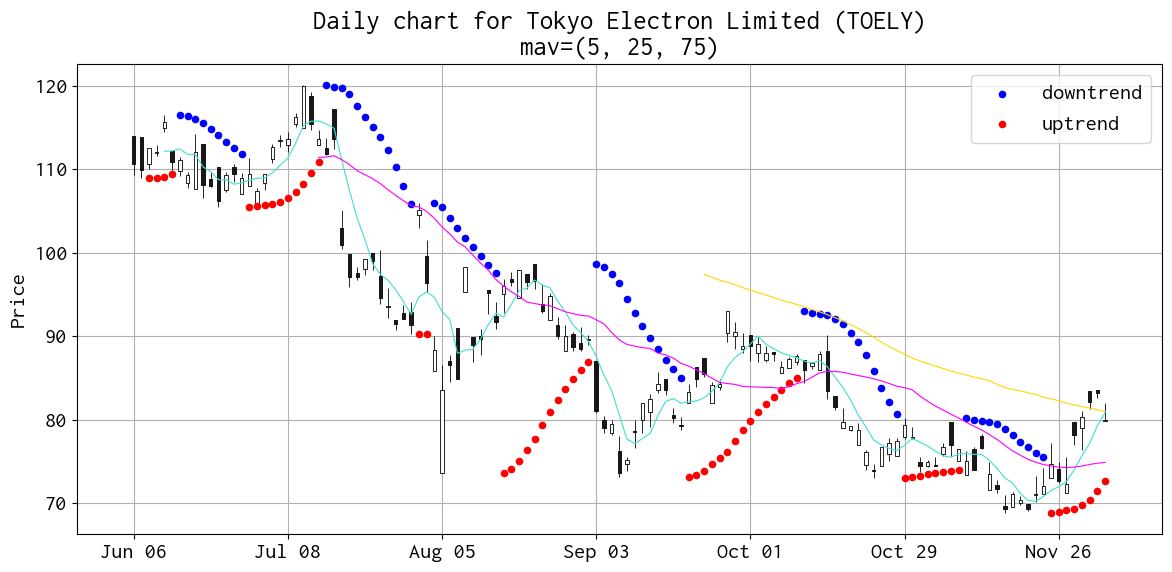

In [8]:
dict_psar = psar(df1)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df1,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker1.info['longName'], symbol1))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol1)

ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_TOELY.png')
plt.show()